upload kaggle.json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harpershen","key":"820ca384b9a6d9fc4dfc8c0d4a654cde"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip -q /content/face-expression-recognition-dataset.zip
!mv /content/images/ ~

kaggle.json
 97% 117M/121M [00:00<00:00, 112MB/s]  
100% 121M/121M [00:00<00:00, 143MB/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import drive
# drive.flush_and_unmount()

Get data

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms
import os


class facialDataset(Dataset):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
    #self.label_dict = {"angry": 0, "disgust": 1, "fear": 1, "happy": 2, "neutral": 3, "sad": 4, "surprise": 1}
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)

class facialDatasetAug(Dataset):
  def __init__(self, directory, transform): # use transform for transfer learning
  # def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
    # use for transfer learning
    self.transform = transform
    
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  # def __getitem__(self, idx):
  #   img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
  #   image = read_image(img_path)
  #   cropper = torchvision.transforms.RandomCrop(46, padding=1, padding_mode='edge');
  #   image = cropper(image)
  #   flipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
  #   image = flipper(image)
  #   image = image.type(torch.float)
  #   label = self.label_dict.get(self.arr[idx][0])
  #   return image, torch.tensor(label)

  # use for transfer learning
  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    image = self.transform(image)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)

  




In [ ]:
from torch.utils.data import DataLoader



trainDataset = facialDataset("/root/images/train")
testDataset = facialDataset("/root/images/validation")

# train_dataloader = DataLoader(trainDataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(testDataset, batch_size=64, shuffle=False)

train_dataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

# train_dataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)
# test_dataloader = DataLoader(testDataset, batch_size=256, shuffle=False)

In [ ]:
print(trainDataset[0][0])
print(trainDataset[0][1])

tensor([[[ 91., 150., 141.,  ..., 172., 169., 160.],
         [ 87., 147., 143.,  ..., 173., 166., 157.],
         [109., 144., 138.,  ..., 173., 161., 155.],
         ...,
         [  0.,   1.,   1.,  ..., 142., 139., 130.],
         [  0.,   1.,   0.,  ..., 137., 132., 126.],
         [  2.,   0.,   0.,  ..., 132., 123., 121.]]])
tensor(1)


Check if device is GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

Add neural network with three layers. Add simple netword from tutorial 2. Add conv netword from tutorial 2

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self, inputs=2304, hidden1=1024, hidden2 = 512, outputs=7):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        #self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc3 = nn.Linear(hidden2, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        # No softmax, happens in loss function
        return 


class SimpleNet(nn.Module):
    def __init__(self, inputs=2304, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1) # Takes image-like to vector-like
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 48*48*1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x16
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)

        # Input 24*24*16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 8x8x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)


        # Exercise left to the reader
        # Output image: 12*12*32 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # Output image: 6*6*34 -> 2304 neurons
        #self.fc1 = nn.Linear(2304, 10)
        self.fc1 = nn.Linear(2304, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x) # Unnormalized Probabilities
        return x


Training Code

In [ ]:
# import numpy
# import torch.optim as optim

# def train(net, dataloader, epochs=1, lr=0.001, momentum=0.0, decay=0.0001, verbose=1):
#   net.to(device)
#   losses = []
#   criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
#   for epoch in range(epochs):
#     sum_loss = 0.0
#     for i, batch in enumerate(dataloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = batch[0].to(device), batch[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize 
#         outputs = net(inputs)
#         #print(outputs)
#         loss = criterion(outputs, labels)
#         loss.backward()  # autograd magic, computes all the partial derivatives
#         optimizer.step() # takes a step in gradient direction

#         # print statistics
#         losses.append(loss.item())
#         sum_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             if verbose:
#               print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, sum_loss / 100))
#             sum_loss = 0.0
#   return losses

# def accuracy(net, dataloader):
#   correct = 0
#   total = 0
#   with torch.no_grad():
#       for batch in dataloader:
#           images, labels = batch[0].to(device), batch[1].to(device)
#           outputs = net(images)
#           _, predicted = torch.max(outputs.data, 1)
#           total += labels.size(0)
#           correct += (predicted == labels).sum().item()
#   return correct/total


Train the first network

In [ ]:
# import matplotlib.pyplot as plt

# net = NeuralNetwork()

# losses = train(net, train_dataloader, epochs=10)
# plt.plot(losses)

# print("Current training accuracy: %f" % accuracy(net, train_dataloader))
# print("Current testing  accuracy: %f" % accuracy(net, test_dataloader))
# # lr                training_accuracy   testing_accuracy
# # 0.00001           0.251622            0.254316
# # 0.0001            0.284896            0.277102
# # 0.001(best)       0.303147            0.303425
# # 0.01(default)     0.249540            0.258704
# # 0.1               0.172860            0.172092
# # 
# # with lr=0.001 (no effect)
# # decay             training_accuracy   testing_accuracy
# # 0.0(default)      0.280906            0.289414
# # 1                 0.248569            0.258279
# # 0.1               0.279900            0.283895
# # 0.01              0.302731            0.305265
# # 0.001             0.289546            0.290829
# # 0.0001            0.305194            0.308378
# # 0.00001           0.290552            0.294933
# # 
# # with lr=0.001 and decay=0.0001 (no effect)
# # momentum          training_accuracy   testing_accuracy
# # 0.0(default)      0.317720            0.312058
# # 1                 0.173034            0.172375
# # 0.1               0.291454            0.297905
# # 0.01              0.288123            0.286584
# # 0.001             0.307866            0.312765
# # 0.0001            0.297214            0.300028

Trainning code for sim and cov

In [ ]:
import numpy
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss() # Combination softmax + negative log likelihood
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  # scheduled learning rate decay
  scheduler = optim.ExponentialLR(optimizer, gamma=0.9)

  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return numpy.convolve(x, numpy.ones(size)/size, mode='valid')

Train the simple network

In [ ]:
# import matplotlib.pyplot as plt

# net = SimpleNet()

# losses = train(net, train_dataloader, epochs=15)
# plt.plot(smooth(losses,50))

# print("Training accuracy: %f" % accuracy(net, train_dataloader))
# print("Testing  accuracy: %f" % accuracy(net, test_dataloader))

Train the cov network

In [ ]:
import matplotlib.pyplot as plt

net = ConvNet()

losses = train(net, train_dataloader, epochs=15, lr=0.0001)
plt.plot(smooth(losses,50))

print("Training accuracy: %f" % accuracy(net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(net, test_dataloader))
# lr                training_accuracy   testing_accuracy
# 0.00001           0.354151            0.344750
# 0.0001(best)      0.437736            0.411265
# 0.001             0.417196            0.395839
# 0.01(default)     0.248569            0.258279
# 0.1               0.248569            0.258279
# 
# with lr=0.0001 (no effect)
# decay             training_accuracy   testing_accuracy
# 0                 0.449290            0.420606
# 0.001             0.445613            0.421738
# 0.01              0.453211            0.416926
# 0.1               0.431803            0.416360



KeyboardInterrupt: ignored

Simulated Annealing

[1,   100] loss: 2.423
[1,   200] loss: 1.804
[2,   100] loss: 1.759
[2,   200] loss: 1.722
[3,   100] loss: 1.687
[3,   200] loss: 1.684
[4,   100] loss: 1.661
[4,   200] loss: 1.638
[5,   100] loss: 1.627
[5,   200] loss: 1.624
[1,   100] loss: 1.602
[1,   200] loss: 1.599
[2,   100] loss: 1.597
[2,   200] loss: 1.598
[3,   100] loss: 1.600
[3,   200] loss: 1.592
[4,   100] loss: 1.602
[4,   200] loss: 1.583
[5,   100] loss: 1.595
[5,   200] loss: 1.580
[1,   100] loss: 1.590
[1,   200] loss: 1.588
[2,   100] loss: 1.589
[2,   200] loss: 1.585
[3,   100] loss: 1.591
[3,   200] loss: 1.580
[4,   100] loss: 1.587
[4,   200] loss: 1.583
[5,   100] loss: 1.579
[5,   200] loss: 1.590
Training accuracy: 0.390167
Testing  accuracy: 0.383385


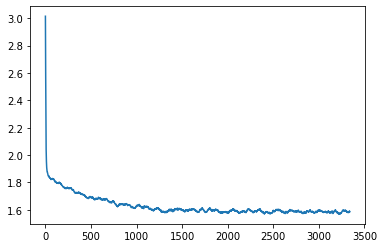

In [ ]:
import matplotlib.pyplot as plt

# (no effect)
anneal_net = ConvNet()

anneal_losses =  train(anneal_net, train_dataloader, epochs=5, lr=.0001)
anneal_losses += train(anneal_net, train_dataloader, epochs=5, lr=.00001)
anneal_losses += train(anneal_net, train_dataloader, epochs=5, lr=.000001)

plt.plot(smooth(anneal_losses, 50))

print("Training accuracy: %f" % accuracy(anneal_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(anneal_net, test_dataloader))

Batch Normalization

In [ ]:
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        #self.fc1 = nn.Linear(2304, 10)
        self.fc1 = nn.Linear(2304, 7)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x



[1,   100] loss: 1.721
[1,   200] loss: 1.594
[2,   100] loss: 1.454
[2,   200] loss: 1.419
[3,   100] loss: 1.311
[3,   200] loss: 1.323
[4,   100] loss: 1.213
[4,   200] loss: 1.220
[5,   100] loss: 1.148
[5,   200] loss: 1.175
[6,   100] loss: 1.074
[6,   200] loss: 1.114
[7,   100] loss: 1.026
[7,   200] loss: 1.054
[8,   100] loss: 0.962
[8,   200] loss: 1.018
[9,   100] loss: 0.911
[9,   200] loss: 0.968
[10,   100] loss: 0.862
[10,   200] loss: 0.937
[11,   100] loss: 0.833
[11,   200] loss: 0.900
[12,   100] loss: 0.806
[12,   200] loss: 0.862
[13,   100] loss: 0.777
[13,   200] loss: 0.834
[14,   100] loss: 0.732
[14,   200] loss: 0.795
[15,   100] loss: 0.712
[15,   200] loss: 0.759
Training accuracy: 0.781930
Testing  accuracy: 0.447920


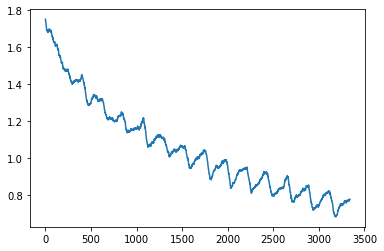

In [ ]:
norm_net = ConvBNNet()

norm_losses = train(norm_net, train_dataloader, epochs=15, lr=.01)

plt.plot(smooth(norm_losses, 50))

print("Training accuracy: %f" % accuracy(norm_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(norm_net, test_dataloader))
# lr                training_accuracy   testing_accuracy 
# 0.001             0.614760            0.436598
# 0.01(default)     0.796954            0.452165
# 0.1               0.492245            0.425984

[1,   100] loss: 1.738
[1,   200] loss: 1.588
[2,   100] loss: 1.438
[2,   200] loss: 1.410
[3,   100] loss: 1.298
[3,   200] loss: 1.307
[4,   100] loss: 1.223
[4,   200] loss: 1.226
[5,   100] loss: 1.136
[5,   200] loss: 1.158
[1,   100] loss: 1.000
[1,   200] loss: 0.977
[2,   100] loss: 0.952
[2,   200] loss: 0.960
[3,   100] loss: 0.930
[3,   200] loss: 0.941
[4,   100] loss: 0.920
[4,   200] loss: 0.928
[5,   100] loss: 0.899
[5,   200] loss: 0.921
[1,   100] loss: 0.877
[1,   200] loss: 0.893
[2,   100] loss: 0.877
[2,   200] loss: 0.890
[3,   100] loss: 0.884
[3,   200] loss: 0.880
[4,   100] loss: 0.882
[4,   200] loss: 0.882
[5,   100] loss: 0.876
[5,   200] loss: 0.885
Training accuracy: 0.697859
Testing  accuracy: 0.471978


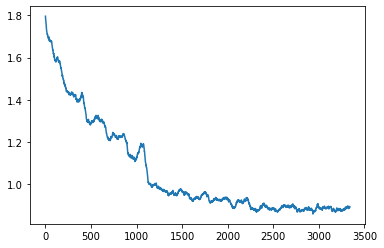

In [ ]:
anneal2_net = ConvBNNet()

anneal2_losses =  train(anneal2_net, train_dataloader, epochs=5, lr=.01)
anneal2_losses += train(anneal2_net, train_dataloader, epochs=5, lr=.001)
anneal2_losses += train(anneal2_net, train_dataloader, epochs=5, lr=.0001)


plt.plot(smooth(anneal2_losses, 50))

print("Training accuracy: %f" % accuracy(anneal2_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(anneal2_net, test_dataloader))

#training_accuracy   testing_accuracy     kernal size
#0.709760            0.474101               3
#0.778842            0.492641               5

Weight Decay

[1,   100] loss: 1.717
[1,   200] loss: 1.564
[2,   100] loss: 1.415
[2,   200] loss: 1.410
[3,   100] loss: 1.322
[3,   200] loss: 1.344
[4,   100] loss: 1.275
[4,   200] loss: 1.291
[5,   100] loss: 1.234
[5,   200] loss: 1.274
[1,   100] loss: 1.162
[1,   200] loss: 1.137
[2,   100] loss: 1.116
[2,   200] loss: 1.113
[3,   100] loss: 1.099
[3,   200] loss: 1.099
[4,   100] loss: 1.093
[4,   200] loss: 1.080
[5,   100] loss: 1.073
[5,   200] loss: 1.078
[1,   100] loss: 1.045
[1,   200] loss: 1.053
[2,   100] loss: 1.045
[2,   200] loss: 1.050
[3,   100] loss: 1.043
[3,   200] loss: 1.044
[4,   100] loss: 1.042
[4,   200] loss: 1.035
[5,   100] loss: 1.036
[5,   200] loss: 1.041
Training accuracy: 0.634399
Testing  accuracy: 0.489952


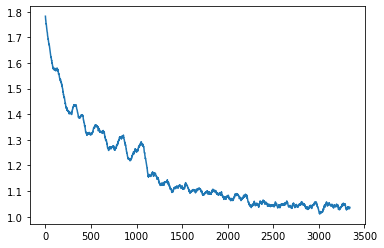

In [ ]:
decay_net = ConvBNNet()

decay_losses =  train(decay_net, train_dataloader, epochs=5, lr=.01  , decay = .01)
decay_losses += train(decay_net, train_dataloader, epochs=5, lr=.001 , decay = .01)
decay_losses += train(decay_net, train_dataloader, epochs=5, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(decay_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(decay_net, test_dataloader))

#training_accuracy   testing_accuracy     kernal size
#0.633115            0.484432               3
#0.713022            0.504953               5

In [ ]:
from torch.utils.data import DataLoader

trainDatasetAug = facialDatasetAug("/root/images/train")
testDatasetAug = facialDatasetAug("/root/images/validation")

train_dataloader_aug = DataLoader(trainDatasetAug, batch_size=128, shuffle=True, num_workers=2)
test_dataloader_aug = DataLoader(testDatasetAug, batch_size=128, shuffle=False, num_workers=2)

data_net = ConvBNNet()

data_losses =  train(data_net, train_dataloader_aug, epochs=20, lr=.01  , decay = .01)
data_losses += train(data_net, train_dataloader_aug, epochs=30, lr=.001 , decay = .01)
data_losses += train(data_net, train_dataloader_aug, epochs=50, lr=.0001, decay = .01)


plt.plot(smooth(data_losses, 50))

print("Training accuracy: %f" % accuracy(data_net, train_dataloader_aug))
print("Testing  accuracy: %f" % accuracy(data_net, test_dataloader_aug))


TypeError: ignored

Transfer Learning

In [ ]:
torch.save(data_net.state_dict(), "./checkpoint.ckp")

In [ ]:
import matplotlib.pyplot as plt
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
transform_train = transforms.Compose([
      transforms.Resize(128),
      transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from 136x136 padded images
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.Lambda(lambda x: x.repeat(3, 1, 1))
      # transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    # transforms.ToTensor(),
  ])


trainDatasetAug = facialDatasetAug("/root/images/train", transform_train)
testDatasetAug = facialDatasetAug("/root/images/validation", transform_test)
train_dataloader_aug = DataLoader(trainDatasetAug, batch_size=128, shuffle=True, num_workers=2)
test_dataloader_aug = DataLoader(testDatasetAug, batch_size=128, shuffle=False, num_workers=2)

model.fc = nn.Linear(512, 7) # Reinitializes final layer, assigns random weights

resnet_losses = train(model, train_dataloader_aug, epochs=50, lr=.01)
print("Training accuracy: %f" % accuracy(model, train_dataloader_aug))
print("Testing accuracy: %f" % accuracy(model, test_dataloader_aug))
plt.plot(smooth(resnet_losses,50))


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   100] loss: 1.477
[1,   200] loss: 1.173
[2,   100] loss: 1.022


KeyboardInterrupt: ignored

Combine category of angry, disgust, fear, surprise

In [ ]:
class facialNewDataset(Dataset):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 0, "fear": 0, "happy": 1, "neutral": 2, "sad": 3, "surprise": 0}
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    image = image.type(torch.float)
    label = self.label_dict[self.arr[idx][0]]
    return image, torch.tensor(label)

trainDataset = facialNewDataset("/root/images/train")
testDataset = facialNewDataset("/root/images/validation")
train_dataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

class ConvBNNet2(nn.Module):
    def __init__(self):
        super(ConvBNNet2, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        #self.fc1 = nn.Linear(2304, 10)
        self.fc1 = nn.Linear(2304, 5)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x



In [ ]:
new_decay_net = ConvBNNet2()
decay_losses =  train(new_decay_net, train_dataloader, epochs=5, lr=.01  , decay = .01)
decay_losses += train(new_decay_net, train_dataloader, epochs=5, lr=.001 , decay = .01)
decay_losses += train(new_decay_net, train_dataloader, epochs=5, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(new_decay_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(new_decay_net, test_dataloader))

Combine category of disgust, fear, surprise

[1,   100] loss: 1.552
[1,   200] loss: 1.422
[2,   100] loss: 1.336
[2,   200] loss: 1.312
[3,   100] loss: 1.280
[3,   200] loss: 1.262
[4,   100] loss: 1.237
[4,   200] loss: 1.245
[5,   100] loss: 1.210
[5,   200] loss: 1.212
[6,   100] loss: 1.209
[6,   200] loss: 1.203
[7,   100] loss: 1.204
[7,   200] loss: 1.194
[8,   100] loss: 1.175
[8,   200] loss: 1.186
[9,   100] loss: 1.189
[9,   200] loss: 1.170
[10,   100] loss: 1.169
[10,   200] loss: 1.172
[11,   100] loss: 1.176
[11,   200] loss: 1.164
[12,   100] loss: 1.157
[12,   200] loss: 1.170
[13,   100] loss: 1.166
[13,   200] loss: 1.157
[14,   100] loss: 1.147
[14,   200] loss: 1.161
[15,   100] loss: 1.151
[15,   200] loss: 1.149
[16,   100] loss: 1.145
[16,   200] loss: 1.145
[17,   100] loss: 1.144
[17,   200] loss: 1.158
[18,   100] loss: 1.151
[18,   200] loss: 1.142
[19,   100] loss: 1.141
[19,   200] loss: 1.143
[20,   100] loss: 1.150
[20,   200] loss: 1.140
[1,   100] loss: 1.091
[1,   200] loss: 1.095
[2,   100] l

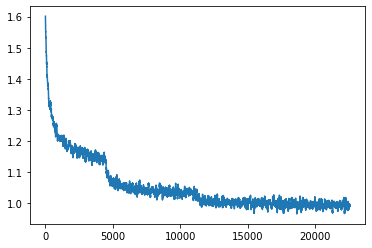

In [ ]:
class NewfacialDatasetAug(Dataset):
  #def __init__(self, directory, transform):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 1, "happy": 2, "neutral": 3, "sad": 4, "surprise": 1}
    # self.transform = transform
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    cropper = torchvision.transforms.RandomCrop(46, padding=1, padding_mode='edge');
    image = cropper(image)
    flipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
    image = flipper(image)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)

trainDatasetAug = NewfacialDatasetAug("/root/images/train")
testDatasetAug = NewfacialDatasetAug("/root/images/validation")

train_dataloader_aug = DataLoader(trainDatasetAug, batch_size=128, shuffle=True, num_workers=2)
test_dataloader_aug = DataLoader(testDatasetAug, batch_size=128, shuffle=False, num_workers=2)

new_decay_net = ConvBNNet2()
decay_losses =  train(new_decay_net, train_dataloader_aug, epochs=100, lr=.01  , decay = .01)
# decay_losses += train(new_decay_net, train_dataloader_aug, epochs=30, lr=.001 , decay = .01)
# decay_losses += train(new_decay_net, train_dataloader_aug, epochs=50, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(new_decay_net, train_dataloader_aug))
print("Testing  accuracy: %f" % accuracy(new_decay_net, test_dataloader_aug))

In [ ]:
import torchvision.transforms as T

try_loader = DataLoader(testDataset, batch_size=4, shuffle=False)

n = 0
with torch.no_grad():
      for batch in try_loader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          n = n-1
          if n == 0:
              break

image = images[0]
image = transforms.ToPILImage()(image)
print(f"true label: {labels[0]}")
print(f"actual label: {predicted[0]}")
image.show()
